# 🥱 LangGraph篇_實作 Plan-and-execute-Agent

在人工智能領域中，"計劃與執行"（Plan-and-Execute）代理是一種強大的工具，能夠通過先制定計劃，再執行子任務的方式來完成複雜目標。這種方法的靈感主要來源於 [BabyAGI](https://github.com/yoheinakajima/babyagi) 項目和 ["Plan-and-Solve"](https://arxiv.org/abs/2305.04091). 論文。

本文將帶您深入了解這種智能代理的工作原理和實現方法。將採用 Agentic Framework LangGraph 實作。

核心概念
- 計劃階段：通常由大型語言模型（LLM）完成，負責制定整體策略和子任務。
- 執行階段：由配備各種工具的獨立代理執行具體任務。

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).


# 環境建置

## 安裝套件包

在深入反思機制之前，我們需要先搭建實驗環境。
這次會使用到 Tavily 搜尋作為工具提供 Agent 使用，可以到[此處](https://app.tavily.com/sign-in) 獲得該服務的 API Key，如果有自己偏好的搜尋服務也可以至換。

以下是所需的套件安裝命令：

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

我們需要設置 環境變數 OPENAI_API_KEY ，可以直接完成，如下所示：

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

> 📌 實用提示：確保所有環境變數都正確設置，這對於順利運行後續程式碼至關重要。

### (可用可不用)LangSmith

你用LangChain構建的許多應用程式將包含多個步驟，並多次調用LLM調用。隨著這些應用程式變得越來越複雜，能夠檢查您的鏈或代理內部到底發生了什麼變得至關重要。最好的方法是與[LangSmith](https://smith.langchain.com)合作。

請注意，LangSmith 不是必需的，但它很有説明。如果您確實想使用 LangSmith，請在上面的鏈接中註冊后，請確保設置環境變數以開始記錄跟蹤：

In [ ]:
import os
import getpass
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %Z")

os.environ["LANGCHAIN_TRACING_V2"] = "true" ##想要使用記得改 true, 不要時改 false.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph 實作Plan-and-Executor-{current_time}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## 定義工具

工具是代理執行任務的關鍵組件。在本例中，我們將使用Tavily提供的搜索工具，這使得代理能夠獲取最新的網絡信息。如果你想要嘗試自己建立工具的話，可以在此查看[文檔](https://python.langchain.com/v0.2/docs/how_to/custom_tools)

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

## 定義執行代理

執行代理是負責實際執行計劃中各個步驟的組件。我們使用LangChain的ReAct代理框架來創建這個執行代理。

In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# 獲取提示（可以根據需要修改）
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

# 選擇驅動代理的語言模型
llm = ChatOpenAI(model="gpt-4-turbo-preview")
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(
<ipython-input-6-c3f36cf11732>:12: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)


In [ ]:
#測試執行代理
agent_executor.invoke({"messages": [("user", "2024 奧運男子組羽毛球雙打冠軍是誰？")]})

{'messages': [HumanMessage(content='2024 奧運男子組羽毛球雙打冠軍是誰？', id='efb6eae0-34bb-49d7-9d9c-630dbf584dd8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZI8wRd5DPA8z0SHAMnlsWXhK', 'function': {'arguments': '{"query":"2024 奧運男子組羽毛球雙打冠軍"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 115, 'total_tokens': 156}, 'model_name': 'gpt-4-0125-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-09987f38-cc0a-4fc6-905c-7a57262d621b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024 奧運男子組羽毛球雙打冠軍'}, 'id': 'call_ZI8wRd5DPA8z0SHAMnlsWXhK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 115, 'output_tokens': 41, 'total_tokens': 156}),
  ToolMessage(content='[{"url": "https://www.vogue.com.tw/entertainment/article/tokyo-olympics-mens-doubles-we-win-gold-medal", "content": "\\u30102024\\u5df4\\

目前資訊還亂糟糟的，至少確認該邏輯可以運作，而且 Search 可以執行，讓我們繼續往下。

## 定義狀態

為了有效地管理代理的執行過程，我們需要定義一個清晰的狀態結構。這個結構將包含以下關鍵信息：
1. input: str
- 這個字段用來存儲原始的用戶輸入。
- 它允許代理在整個執行過程中參考原始任務。

2. plan: List[str]
- 這個列表用來存儲當前的計劃。
- 每個字符串代表計劃中的一個步驟。

3. past_steps: Annotated[List[Tuple[str, str]], operator.add]

- 這個列表用來追踹已執行的步驟。
- 每個元組包含兩個元素：
 - 第一個元素是執行的步驟（字符串）
 - 第二個元素是該步驟的執行結果（字符串）
- 使用 Annotated 和 operator.add 表示這個列表可以通過加法操作進行更新。

4. response: str
- 這個字段用來存儲最終的回應。
- 當代理完成所有任務後，最終的答案將存儲在這裡。

In [ ]:
import operator
from typing import Annotated, List, Tuple, TypedDict

class PlanExecute(TypedDict):
    input: str  # 原始輸入
    plan: List[str]  # 當前計劃
    past_steps: Annotated[List[Tuple], operator.add]  # 已執行的步驟
    response: str  # 最終響應

這個結構允許我們追踪整個執行過程，包括初始輸入、當前計劃、已完成的步驟以及最終的響應。

## 規劃步驟

規劃是整個過程的核心。它負責生成初始計劃。我們將使用 OpenAI 的語言模型來生成這個計劃。

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [ ]:
planner.invoke(
    {
        "messages": [
            ("user", "2024 奧運男子組羽毛球雙打冠軍是誰?")
        ]
    }
)

Plan(steps=['查找2024年奧運會羽毛球男子雙打比賽的結果', '確定冠軍隊伍的成員', '提供冠軍隊伍成員的名字'])

這個規劃器會根據輸入生成一個結構化的計劃。使用 temperature=0 可以確保輸出的一致性。

## 重新規劃步驟

重新規劃步驟允許代理根據已執行的步驟和新獲得的信息來調整計劃。


In [ ]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

這個重新規劃器會根據當前的執行狀態來決定是繼續執行還是提供最終回應。


## 創建工作流程圖

現在，讓我們使用 LangGraph 來創建完整的工作流程圖：


### 定義節點函數

In [ ]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    # make past_steps as list and append task, agent_response["messages"][-1].content)
    past_steps_list = []
    past_steps_list.append(task)
    past_steps_list.append(agent_response["messages"][-1].content)
    return {
        "past_steps": past_steps_list,
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

### 編譯整張圖

In [ ]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

這個工作流程圖定義了代理的整體行為：從規劃開始，然後執行任務，之後重新評估並決定是繼續執行還是結束。

#### 視覺化整張圖

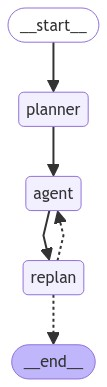

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### 執行範例
最後，讓我們運行一個範例來測試我們的"Plan-and-Execute" Agent：

In [ ]:
import rich
config = {"recursion_limit": 50}
inputs = {"input": "2024 奧運男子組羽毛球雙打冠軍是誰?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)
        if k == "response":
            rich.print("Agent says: ", v)

{'plan': ['查找2024年奧運會羽毛球男子雙打比賽的結果。', '確定冠軍隊伍的名字。', '返回冠軍隊伍的名字。']}
{'past_steps': ['查找2024年奧運會羽毛球男子雙打比賽的結果。', '2024年奥运会羽毛球男子双打比赛的结果是，来自Chinese Taipei的组合李洋/王齐麟以2-1的比分战胜了中国组合梁维铿/王昶，夺得了冠军。']}
{'response': '2024年奧運男子組羽毛球雙打冠軍是來自Chinese Taipei的組合李洋/王齊麟。'}


> 溫腥提示：我無法確定當前的你需要執行幾次才可以達到想要的答案，該方法很大一塊邏輯是在 Planner 身上。

## 結論

恭喜您成功打造了一個計劃與執行代理！然而，當前設計仍存在一些值得優化的空間。最顯著的限制在於其任務執行模式：目前，所有操作都是按照嚴格的順序進行的。這意味著即使是那些本可以同時進行的任務，也被強制納入了總執行時間的計算中，這無疑是一種效率上的損失。

為了突破這一瓶頸，我們建議採用更先進的任務表示方法。具體而言，您可以考慮將每個任務構建為有向無環圖（DAG）的形式，而不是簡單的線性列表。這種方法與LLMCompiler的核心理念不謀而合，它能夠有效地識別和利用任務間的並行潛力。